In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
import re
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc, confusion_matrix
from tqdm.notebook import tqdm

sys.path.insert(0, '..')

from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from models.nt_classifier import build as build_model
from config import *
from util.plot_utils import obtain_plot, plot_logs, plot_roc_curves, collect_results_based_on_confidence_level, various_metrics
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

<class 'transformers.tokenization_dna.DNATokenizer'>


In [3]:
intarna = pd.read_csv(os.path.join(intarna_dir, 'val500', 'val.csv'), sep = ';')
intarna['key'] = intarna.id1 + '_' + intarna.id2

# keep only the lower E_norm for each group
intarna.sort_values('E_norm', ascending = False, inplace=True)
intarna.drop_duplicates(subset='key', keep='first', inplace=True)
intarna = intarna.reset_index(drop = True)
intarna['couples'] = intarna.id1.str.extractall('(.*)_(.*)').reset_index(drop = True)[0]
intarna['couples'] = intarna['couples'].astype(int)

In [4]:
MODEL = 'NT' #NT

if MODEL == 'BERT':
    checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints_bert')
    models_to_compare = {}
    for file in os.listdir(checkpoint_dir):
        if file.startswith('binary_cl'):
            if file.endswith('binary_cl'):
                nickname = 'current'
            else:
                nickname = re.search('(binary_cl)_(.*)', file).group(2)
            nickname = 'model_' + nickname
            try:
                res = pd.read_csv(os.path.join(checkpoint_dir, file, 'val_results500.csv'))
                res = res.merge(intarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')
                models_to_compare[nickname] = {'original_name': file, 'df': res}
            except:
                pass
            
elif MODEL == 'NT':
    models_to_compare = {}
    checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints')
    for file in os.listdir(checkpoint_dir):
        if file.startswith('binary_cl2'):
            if file.endswith('binary_cl2'):
                nickname = 'current'
            else:
                nickname = re.search('(binary_cl2)_(.*)', file).group(2)
            nickname = 'model_' + nickname
            try:
                res = pd.read_csv(os.path.join(checkpoint_dir, file, 'val_results500.csv'))
                res = res.merge(intarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')
                models_to_compare[nickname] = {'original_name': file, 'df': res}
            except:
                pass

In [5]:
file_train = os.path.join(rna_rna_files_dir, "gene_pairs_training_nt.txt")
with open(file_train, "rb") as fp:   # Unpickling
    gene_pairs_train = pickle.load(fp)
    
file_test = os.path.join(rna_rna_files_dir, "gene_pairs_val_nt.txt")
with open(file_test, "rb") as fp:   # Unpickling
    gene_pairs_test = pickle.load(fp)
    
file_test_subset = os.path.join(rna_rna_files_dir, "gene_pairs_val_sampled_nt.txt")
with open(file_test_subset, "rb") as fp:   # Unpickling
    gene_pairs_test_subset = pickle.load(fp)

In [6]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
regex = df_nt[df_nt.couples.isin(gene_pairs_train)].couples_id.str.extractall('(.*)_(.*)').reset_index()
df_train = regex
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

In [7]:
test500 = pd.read_csv(os.path.join(metadata_dir, 'val500.csv'))
test500['seed_w'] = test500['seed_x2'] - test500['seed_x1']
test500['seed_h'] = test500['seed_y2'] - test500['seed_y1']

In [8]:
assert test500.couples.isin(gene_pairs_test).all()

# PLOTS

In [9]:
N_iters = 25

In [10]:
def balance_df(df):
    negs = df[df.ground_truth == 0]
    poss = df[df.ground_truth == 1]
    
    n_to_sample = min(poss.shape[0], negs.shape[0])

    if poss.shape[0] > negs.shape[0]:
        return pd.concat([poss.sample(n_to_sample), negs], axis = 0).reset_index(drop = True)
    else:
        return pd.concat([negs.sample(n_to_sample), poss], axis = 0).reset_index(drop = True)

In [11]:
results = {}
set_collected = []

In [12]:
key_name = 'full_data'
results[key_name] = {}
set_collected.append(key_name)
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/20 [00:00<?, ?it/s]

In [13]:
key_name = 'easypos_easyneg_hardneg'
results[key_name] = {}
set_collected.append(key_name)
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'easyneg', 'hardneg'])]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/20 [00:00<?, ?it/s]

In [14]:
key_name = 'easypos_easyneg_hardneg_not_in_train'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'easyneg', 'hardneg'])]
    res = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/20 [00:00<?, ?it/s]

In [15]:
key_name = 'easypos_smartneg'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'smartneg'])]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/20 [00:00<?, ?it/s]

In [16]:
key_name = 'easypos_smartneg_not_in_train'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'smartneg'])]
    res = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/20 [00:00<?, ?it/s]

In [17]:
key_name = 'easypos_smartneg_not_in_train_55_conf'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'smartneg'])]
    res = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]
    res = res[(res.probability>0.55)|(res.probability<(1-0.55))]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

key_name = 'easypos_smartneg_not_in_train_6_conf'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'smartneg'])]
    res = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]
    res = res[(res.probability>0.6)|(res.probability<(1-0.6))]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result    

key_name = 'easypos_smartneg_not_in_train_65_conf'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'smartneg'])]
    res = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]
    res = res[(res.probability>0.65)|(res.probability<(1-0.65))]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

key_name = 'easypos_smartneg_not_in_train_7_conf'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'smartneg'])]
    res = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]
    res = res[(res.probability>0.7)|(res.probability<(1-0.7))]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    try:
        fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
        roc = auc(fpr, tpr)
    except:
        roc = np.nan
    try:
        fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
        roc_intarna =  auc(fpr, tpr)
    except:
        roc_intarna = np.nan
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result
    
key_name = 'easypos_smartneg_not_in_train_75_conf'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'smartneg'])]
    res = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]
    res = res[(res.probability>0.75)|(res.probability<(1-0.75))]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    try:
        fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
        roc = auc(fpr, tpr)
    except:
        roc = np.nan
    try:
        fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
        roc_intarna =  auc(fpr, tpr)
    except:
        roc_intarna = np.nan
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result
    
key_name = 'easypos_smartneg_not_in_train_80_conf'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'smartneg'])]
    res = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]
    res = res[(res.probability>0.80)|(res.probability<(1-0.80))]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    try:
        fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
        roc = auc(fpr, tpr)
    except:
        roc = np.nan
    try:
        fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
        roc_intarna =  auc(fpr, tpr)
    except:
        roc_intarna = np.nan
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [18]:
tresholds = [25,28,30,33,37,41,47,52]

for treshold in tresholds:
    key_name = f'easypos_smartneg_HQ_{treshold}'
    set_collected.append(key_name)
    results[key_name] = {}
    for model in tqdm(models_to_compare.keys()):
        res = models_to_compare[model]['df']
        res = res[res.policy.isin(['easypos', 'smartneg'])]
        tot = res.shape[0]
        res = res.merge(test500[['couples', 'seed_w', 'seed_h']].rename({'couples':'id_sample'}, axis = 1), on = 'id_sample')
        res = res[(res.seed_w > treshold) & (res.seed_h > treshold)]
        perc = np.round(res.shape[0]/tot * 100, 2)
        res_list = []
        for i in range(N_iters):
            res_balanced = balance_df(res)
            res_list.append(res_balanced)
        res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
        acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
        fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
        roc = auc(fpr, tpr)
        fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
        roc_intarna =  auc(fpr, tpr)
        dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                       'f2':f2, 'specificity':specificity, 'npv':npv, 
                       'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
        results[key_name][model] = dict_result

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [19]:
treshold = 25
key_name = f'easypos_smartneg_not_in_train_HQ{treshold}'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    res = res[res.policy.isin(['easypos', 'smartneg'])]
    tot = res.shape[0]
    res = res.merge(test500[['couples', 'seed_w', 'seed_h']].rename({'couples':'id_sample'}, axis = 1), on = 'id_sample')
    res = res[(res.seed_w > treshold) & (res.seed_h > treshold)]
    res = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/20 [00:00<?, ?it/s]

In [20]:
metric_to_print = 'acc'
for current_set in set_collected:
    print('--- ', current_set, ' --- ')
    for model in models_to_compare.keys():
        metric = np.round(results[current_set][model][metric_to_print], 3)
        print(model + f' {metric_to_print}:', metric)
    print('\n')

---  full_data  --- 
model_14e34 acc: 0.576
model_1 acc: 0.575
model_2 acc: 0.569
model_4 acc: 0.553
model_5 acc: 0.553
model_old acc: 0.575
model_6 acc: 0.555
model_3 acc: 0.562
model_7 acc: 0.574
model_8 acc: 0.568
model_10e13 acc: 0.575
model_10e34 acc: 0.573
model_11 acc: 0.57
model_12e34 acc: 0.574
model_13e22 acc: 0.571
model_13e23 acc: 0.575
model_12e15 acc: 0.574
model_13e27 acc: 0.577
model_14e13 acc: 0.572
model_10e18 acc: 0.575


---  easypos_easyneg_hardneg  --- 
model_14e34 acc: 0.654
model_1 acc: 0.672
model_2 acc: 0.662
model_4 acc: 0.633
model_5 acc: 0.641
model_old acc: 0.647
model_6 acc: 0.638
model_3 acc: 0.642
model_7 acc: 0.667
model_8 acc: 0.653
model_10e13 acc: 0.666
model_10e34 acc: 0.691
model_11 acc: 0.641
model_12e34 acc: 0.68
model_13e22 acc: 0.649
model_13e23 acc: 0.666
model_12e15 acc: 0.664
model_13e27 acc: 0.66
model_14e13 acc: 0.641
model_10e18 acc: 0.666


---  easypos_easyneg_hardneg_not_in_train  --- 
model_14e34 acc: 0.617
model_1 acc: 0.605
model_2

In [21]:
metric_to_print = 'roc'
for current_set in set_collected:
    print('--- ', current_set, ' --- ')
    for model in models_to_compare.keys():
        metric = np.round(results[current_set][model][metric_to_print], 3)
        print(model + f' {metric_to_print}:', metric)
    print('\n')

---  full_data  --- 
model_14e34 roc: 0.613
model_1 roc: 0.61
model_2 roc: 0.602
model_4 roc: 0.581
model_5 roc: 0.579
model_old roc: 0.613
model_6 roc: 0.584
model_3 roc: 0.593
model_7 roc: 0.61
model_8 roc: 0.604
model_10e13 roc: 0.612
model_10e34 roc: 0.608
model_11 roc: 0.607
model_12e34 roc: 0.608
model_13e22 roc: 0.609
model_13e23 roc: 0.61
model_12e15 roc: 0.606
model_13e27 roc: 0.613
model_14e13 roc: 0.604
model_10e18 roc: 0.611


---  easypos_easyneg_hardneg  --- 
model_14e34 roc: 0.739
model_1 roc: 0.745
model_2 roc: 0.755
model_4 roc: 0.72
model_5 roc: 0.727
model_old roc: 0.705
model_6 roc: 0.722
model_3 roc: 0.701
model_7 roc: 0.735
model_8 roc: 0.708
model_10e13 roc: 0.724
model_10e34 roc: 0.768
model_11 roc: 0.704
model_12e34 roc: 0.757
model_13e22 roc: 0.73
model_13e23 roc: 0.737
model_12e15 roc: 0.728
model_13e27 roc: 0.73
model_14e13 roc: 0.698
model_10e18 roc: 0.734


---  easypos_easyneg_hardneg_not_in_train  --- 
model_14e34 roc: 0.702
model_1 roc: 0.688
model_2 ro

In [22]:
metric_to_print = 'perc_data'
for current_set in set_collected:
    print('--- ', current_set, ' --- ')
    for model in models_to_compare.keys():
        metric = np.round(results[current_set][model][metric_to_print], 3)
        print(model + f' {metric_to_print}:', metric)
    print('\n')

---  full_data  --- 
model_14e34 perc_data: 100.0
model_1 perc_data: 100.0
model_2 perc_data: 100.0
model_4 perc_data: 100.0
model_5 perc_data: 100.0
model_old perc_data: 100.0
model_6 perc_data: 100.0
model_3 perc_data: 100.0
model_7 perc_data: 100.0
model_8 perc_data: 100.0
model_10e13 perc_data: 100.0
model_10e34 perc_data: 100.0
model_11 perc_data: 100.0
model_12e34 perc_data: 100.0
model_13e22 perc_data: 100.0
model_13e23 perc_data: 100.0
model_12e15 perc_data: 100.0
model_13e27 perc_data: 100.0
model_14e13 perc_data: 100.0
model_10e18 perc_data: 100.0


---  easypos_easyneg_hardneg  --- 
model_14e34 perc_data: 36.65
model_1 perc_data: 36.65
model_2 perc_data: 36.65
model_4 perc_data: 36.65
model_5 perc_data: 36.65
model_old perc_data: 36.65
model_6 perc_data: 36.65
model_3 perc_data: 36.65
model_7 perc_data: 36.65
model_8 perc_data: 36.65
model_10e13 perc_data: 36.65
model_10e34 perc_data: 36.65
model_11 perc_data: 36.65
model_12e34 perc_data: 36.65
model_13e22 perc_data: 36.65
m

### Plots

In [23]:
#modify the results dict

m = list(results['full_data'].keys())[0]

# Iterate through the outer dictionary
for key1 in results.keys():
    inner_dict = results[key1]

    # Create a new 'intarna' dictionary with np.nan values
    intarna_dict = {key: np.nan for key in inner_dict[m].keys()}
    
    intarna_roc_value = inner_dict[m]['roc_intarna']

    # Remove 'roc_intarna' from all inner dictionaries
    for key2 in inner_dict.keys():
        if 'roc_intarna' in inner_dict[key2]:
            del inner_dict[key2]['roc_intarna']

    # Add 'intarna' dictionary with 'roc' field set to 'roc_intarna'
    inner_dict['intarna'] = {**intarna_dict}
    inner_dict['intarna']['roc'] = intarna_roc_value

In [24]:
def plot_bars(values, metric_labels, models_label, title):
    # Set width of bar
    barWidth = 0.1
    fig, ax = plt.subplots(figsize=(12, 8))
    
    brs = []
    brs.append(np.arange(len(metric_to_print)))
    for i in range(len(best_models)):
        brs.append([x + barWidth for x in brs[i]])
    
    colors = 'crgybkm'
    
    for i in range(len(best_models)):
        plt.bar(brs[i], values[i], color=colors[i], width=barWidth,
                edgecolor='grey', label=best_models[i])
        
        # Add value labels on top of each bar
        for j, value in enumerate(values[i]):
            ax.text(brs[i][j], value + 0.01, str(np.round(value, 2)), ha='center', va='bottom')
        
    plt.xlabel('Metric', fontweight='bold', fontsize=12)
    plt.ylabel('Metric value', fontweight='bold', fontsize=12)
    plt.xticks([r + barWidth for r in range(len(metric_to_print))], metric_to_print)
    plt.title(title, fontweight='bold', fontsize=20)
    plt.legend()
    plt.show()

In [30]:
if MODEL == 'BERT':
    best_models = ['model_1_54', 'model_1_62', 'model_1_78', 'model_1_89']
elif MODEL == 'NT':
    best_models = ['model_1', 'model_10e18', 'model_12e15', 'model_12e34', 'model_13e23', 'model_13e27']

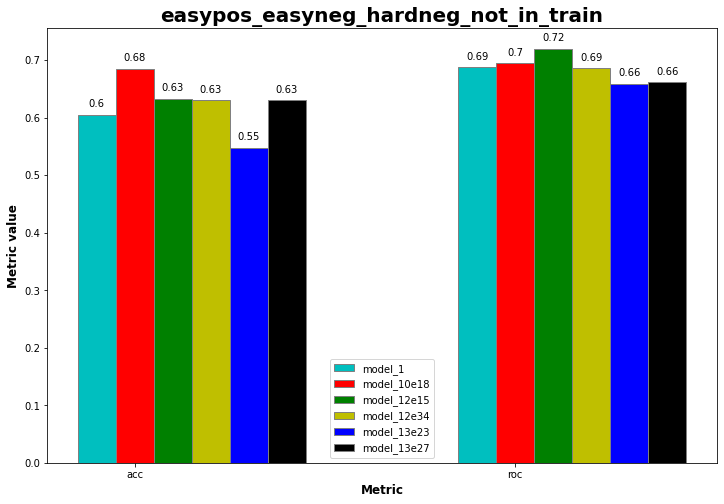

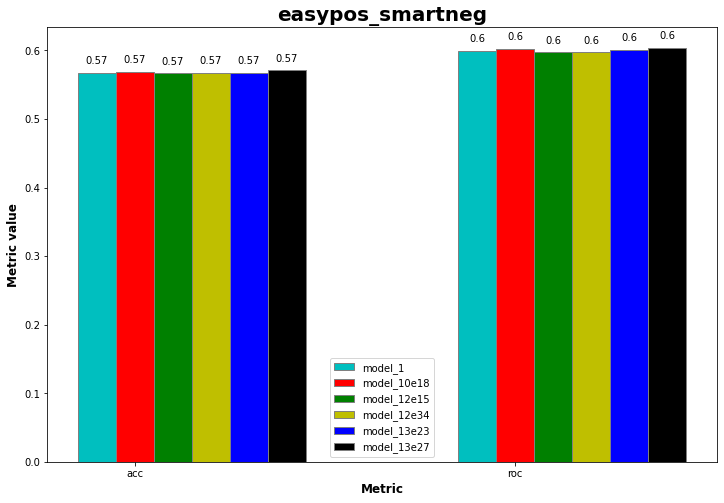

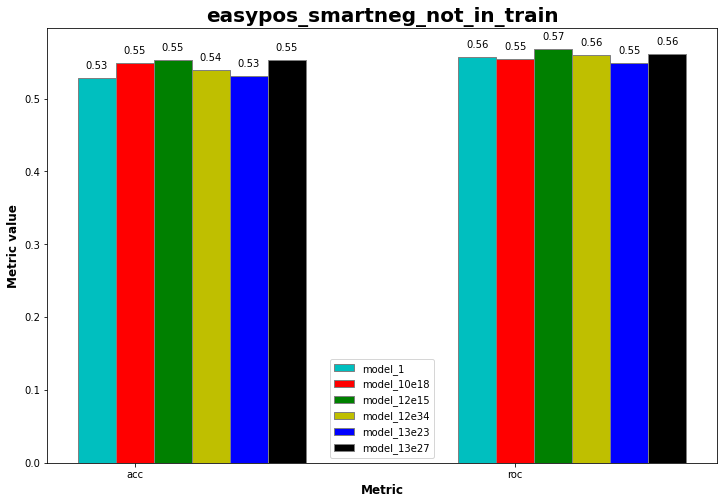

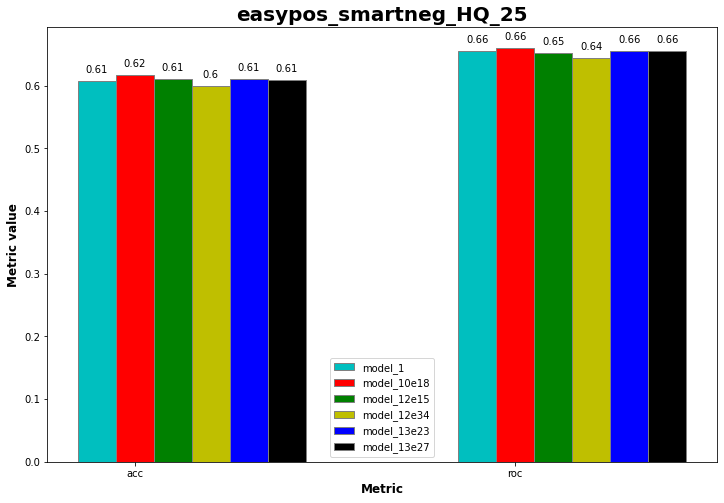

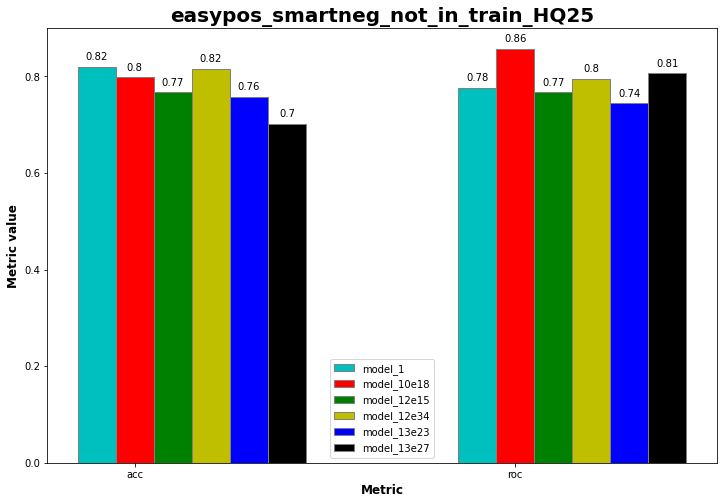

In [31]:
set_to_print = ['easypos_easyneg_hardneg_not_in_train', 'easypos_smartneg', 'easypos_smartneg_not_in_train', 'easypos_smartneg_HQ_25', 'easypos_smartneg_not_in_train_HQ25']#, 'easypos_smartneg_not_in_train_55_conf', 'easypos_smartneg_not_in_train_65_conf']

for current_set in set_to_print:
    if current_set in ['easypos_smartneg_not_in_train_65_conf', 'easypos_smartneg_not_in_train_55_conf']:
        metric_to_print = ['acc', 'roc', 'perc_data']
    else:
        metric_to_print = ['acc', 'roc']
    
    values = []
    for model in best_models:
        if model == 'intarna':
            original_name = 'intarna'
        else:
            original_name = models_to_compare[model]['original_name']
        model_list = []
        for metric in metric_to_print:
            model_list.append(results[current_set][model][metric])
        values.append(model_list)
    
    plot_bars(values, metric_labels = metric_to_print, models_label = best_models, title = current_set)

Text(0.5, 1.0, 'Perc X confidence level')

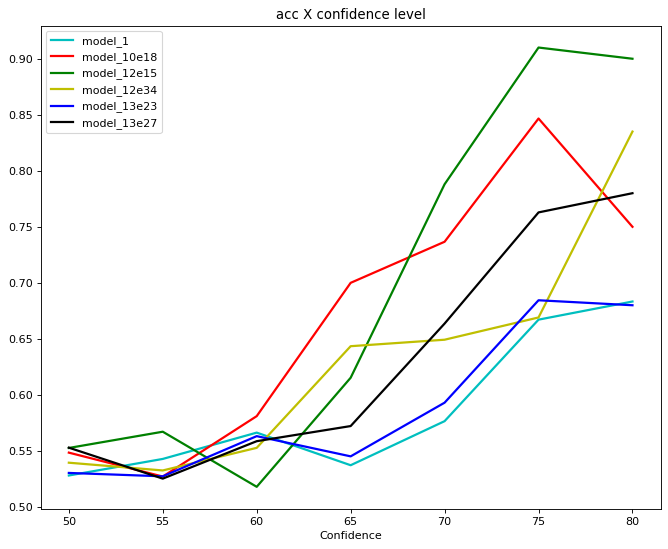

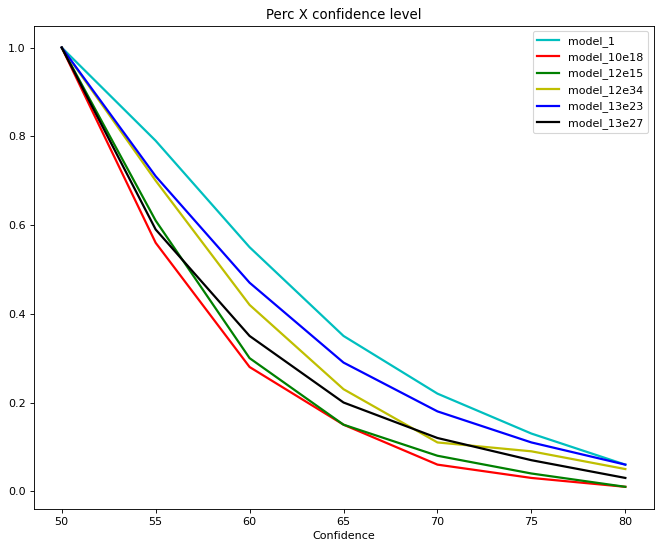

In [32]:
conf_levels = ['easypos_smartneg_not_in_train', 'easypos_smartneg_not_in_train_55_conf', 'easypos_smartneg_not_in_train_6_conf', 'easypos_smartneg_not_in_train_65_conf', 'easypos_smartneg_not_in_train_7_conf', 'easypos_smartneg_not_in_train_75_conf', 'easypos_smartneg_not_in_train_80_conf']
metric = 'acc'

plot_conf = {}

for model in best_models:
    plot_conf[model] = {}
    plot_conf[model][metric] = []
    plot_conf[model]['perc_data'] = []
    for conf_level in conf_levels:
        plot_conf[model][metric].append(results[conf_level][model][metric])
        plot_conf[model]['perc_data'].append(results[conf_level][model]['perc_data'])

# -------------- -------------- --------------

plt.figure(figsize=(10, 8), dpi=80)
colors = 'crgybkm'
confidences = np.array([50, 55, 60, 65, 70, 75, 80])
for i, model in enumerate(best_models):
    plt.plot(confidences, plot_conf[model][metric], label = model, linewidth=2, color = colors[i])
    
plt.legend()
plt.xlabel(f"Confidence")
plt.title(f'{metric} X confidence level')

# -------------- -------------- --------------

plt.figure(figsize=(10, 8), dpi=80)
colors = 'crgybkm'
confidences = np.array([50, 55, 60, 65, 70, 75, 80])
for i, model in enumerate(best_models):
    plt.plot(confidences, plot_conf[model]['perc_data'], label = model, linewidth=2, color = colors[i])
    
plt.legend()
plt.xlabel(f"Confidence")
plt.title('Perc X confidence level')

Text(0.5, 1.0, 'Perc X treshold level')

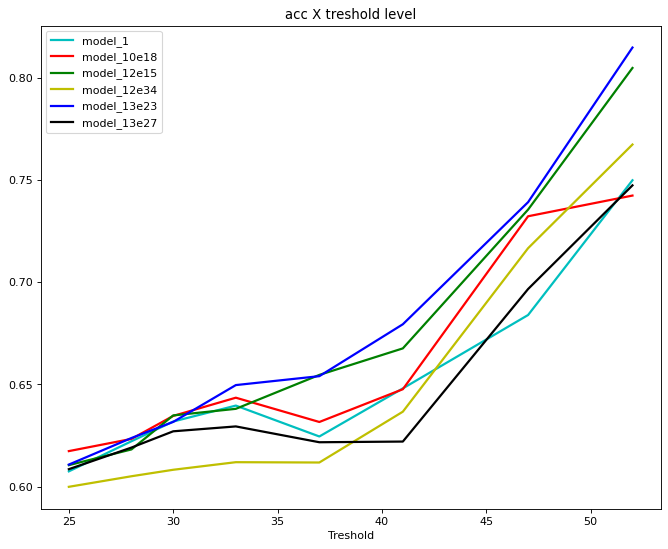

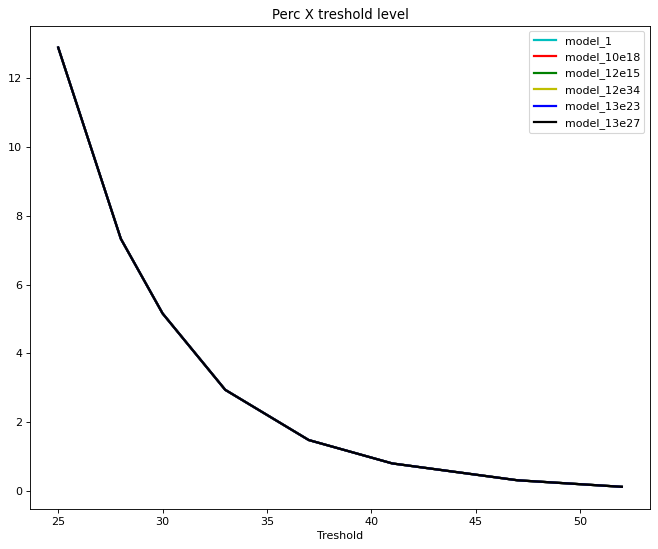

In [33]:
conf_levels = ['easypos_smartneg_HQ_25', 'easypos_smartneg_HQ_28', 'easypos_smartneg_HQ_30', 'easypos_smartneg_HQ_33', 'easypos_smartneg_HQ_37', 'easypos_smartneg_HQ_41', 'easypos_smartneg_HQ_47', 'easypos_smartneg_HQ_52']
metric = 'acc'

plot_conf = {}

for model in best_models:
    plot_conf[model] = {}
    plot_conf[model][metric] = []
    plot_conf[model]['perc_data'] = []
    for conf_level in conf_levels:
        plot_conf[model][metric].append(results[conf_level][model][metric])
        plot_conf[model]['perc_data'].append(results[conf_level][model]['perc_data'])

# -------------- -------------- --------------

plt.figure(figsize=(10, 8), dpi=80)
colors = 'crgybkm'
confidences = np.array(tresholds)
for i, model in enumerate(best_models):
    plt.plot(confidences, plot_conf[model][metric], label = model, linewidth=2, color = colors[i])
    
plt.legend()
plt.xlabel(f"Treshold")
plt.title(f'{metric} X treshold level')

# -------------- -------------- --------------

plt.figure(figsize=(10, 8), dpi=80)
colors = 'crgybkm'
confidences = np.array(tresholds)
for i, model in enumerate(best_models):
    plt.plot(confidences, plot_conf[best_models[0]]['perc_data'], label = model, linewidth=2, color = colors[i])
    
plt.legend()
plt.xlabel(f"Treshold")
plt.title('Perc X treshold level')

Text(0.5, 1.0, 'recall X treshold level')

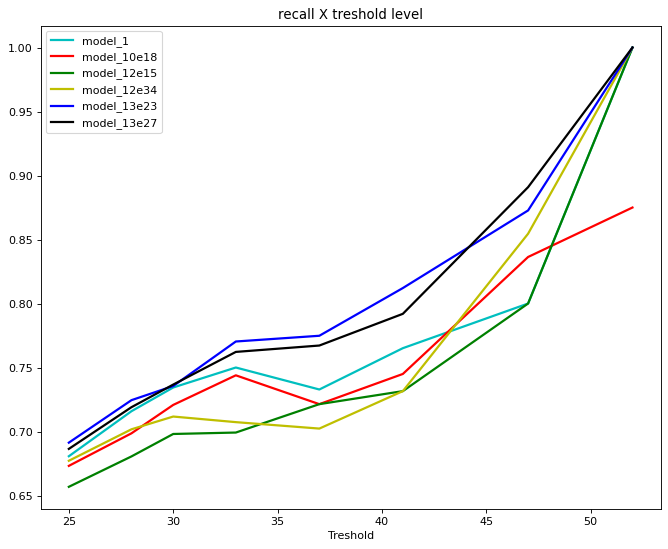

In [34]:
conf_levels = ['easypos_smartneg_HQ_25', 'easypos_smartneg_HQ_28', 'easypos_smartneg_HQ_30', 'easypos_smartneg_HQ_33', 'easypos_smartneg_HQ_37', 'easypos_smartneg_HQ_41', 'easypos_smartneg_HQ_47', 'easypos_smartneg_HQ_52']
metric = 'recall'

plot_conf = {}

for model in best_models:
    plot_conf[model] = {}
    plot_conf[model][metric] = []
    plot_conf[model]['perc_data'] = []
    for conf_level in conf_levels:
        plot_conf[model][metric].append(results[conf_level][model][metric])
        plot_conf[model]['perc_data'].append(results[conf_level][model]['perc_data'])

# -------------- -------------- --------------

plt.figure(figsize=(10, 8), dpi=80)
colors = 'crgybkm'
confidences = np.array(tresholds)
for i, model in enumerate(best_models):
    plt.plot(confidences, plot_conf[model][metric], label = model, linewidth=2, color = colors[i])
    
plt.legend()
plt.xlabel(f"Treshold")
plt.title(f'{metric} X treshold level')


### Explore best configuration

In [29]:
best_model_chosen = 'model_1'


# Define the path to the file containing the args namespace
args_path = os.path.join(ROOT_DIR, 'checkpoints', models_to_compare[best_model_chosen]['original_name'], 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)
    
print(args_dict)
print(args_dict['policies_train'][0].height_bins)
print(args_dict['policies_train'][0].height_probabilities)

{'lr': 0.0001, 'lr_backbone': 0.0001, 'batch_size': 32, 'weight_decay': 0.0001, 'epochs': 100, 'lr_drop': 200, 'clip_max_norm': 0.1, 'proj_module_N_channels': 0, 'proj_module_secondary_structure_N_channels': 4, 'drop_secondary_structure': False, 'use_projection_module': False, 'dropout_prob': 0.01, 'args.mini_batch_size': 32, 'num_hidden_layers': 1, 'dividing_factor': 20, 'output_channels_mlp': 256, 'n_channels1_cnn': 256, 'n_channels2_cnn': 512, 'min_n_groups_train': 5, 'max_n_groups_train': 80, 'min_n_groups_val': 80, 'max_n_groups_val': 80, 'policies_train': [<dataset.data.EasyPosAugment object at 0x7f446aa59460>, <dataset.data.SmartNegAugment object at 0x7f446a82c250>], 'policies_val': [<dataset.data.EasyPosAugment object at 0x7f447e2e2940>, <dataset.data.SmartNegAugment object at 0x7f44693c7970>], 'dataset_path': '/data01/giorgio/RNARNA-NT/dataset', 'device': 'cuda', 'seed': 42, 'num_workers': 2, 'output_dir': '/data01/giorgio/RNARNA-NT/checkpoints/binary_cl2', 'resume': '', 'star

In [30]:
best_model_chosen = 'model_10e34'


# Define the path to the file containing the args namespace
args_path = os.path.join(ROOT_DIR, 'checkpoints', models_to_compare[best_model_chosen]['original_name'], 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)
    
print(args_dict)
print(args_dict['policies_train'][0].height_bins)
print(args_dict['policies_train'][0].height_probabilities)

{'lr': 0.0001, 'lr_backbone': 0.0001, 'batch_size': 32, 'weight_decay': 0.0001, 'epochs': 100, 'lr_drop': 200, 'clip_max_norm': 0.1, 'proj_module_N_channels': 0, 'proj_module_secondary_structure_N_channels': 4, 'drop_secondary_structure': False, 'use_projection_module': False, 'dropout_prob': 0.01, 'args.mini_batch_size': 32, 'num_hidden_layers': 0, 'dividing_factor': 10, 'output_channels_mlp': 512, 'n_channels1_cnn': 400, 'n_channels2_cnn': 800, 'min_n_groups_train': 5, 'max_n_groups_train': 80, 'min_n_groups_val': 80, 'max_n_groups_val': 80, 'policies_train': [<dataset.data.EasyPosAugment object at 0x7f446afd2d60>, <dataset.data.SmartNegAugment object at 0x7f446afd2f10>], 'policies_val': [<dataset.data.EasyPosAugment object at 0x7f45bb91b190>, <dataset.data.SmartNegAugment object at 0x7f446ae49dc0>], 'dataset_path': '/data01/giorgio/RNARNA-NT/dataset', 'device': 'cuda', 'seed': 42, 'num_workers': 2, 'output_dir': '/data01/giorgio/RNARNA-NT/checkpoints/binary_cl2', 'resume': '', 'star